In [ ]:
import zipfile

zip=zipfile.ZipFile("/content/drive/MyDrive/UROP/Forest Segmented.zip",'r')
zip.extractall()
zip.close()

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves

--2023-11-26 14:21:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-26 14:21:03 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(23)

In [ ]:
## resizing images
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

In [ ]:
image_path = "Forest Segmented/images/*.jpg"
mask_path = "Forest Segmented/masks/*.jpg"

In [ ]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [ ]:
image_names[:10]

['Forest Segmented/images/10452_sat_08.jpg',
 'Forest Segmented/images/10452_sat_18.jpg',
 'Forest Segmented/images/111335_sat_00.jpg',
 'Forest Segmented/images/111335_sat_01.jpg',
 'Forest Segmented/images/111335_sat_02.jpg',
 'Forest Segmented/images/111335_sat_03.jpg',
 'Forest Segmented/images/111335_sat_04.jpg',
 'Forest Segmented/images/111335_sat_07.jpg',
 'Forest Segmented/images/111335_sat_08.jpg',
 'Forest Segmented/images/111335_sat_10.jpg']

In [ ]:
mask_names[:10]

['Forest Segmented/masks/10452_mask_08.jpg',
 'Forest Segmented/masks/10452_mask_18.jpg',
 'Forest Segmented/masks/111335_mask_00.jpg',
 'Forest Segmented/masks/111335_mask_01.jpg',
 'Forest Segmented/masks/111335_mask_02.jpg',
 'Forest Segmented/masks/111335_mask_03.jpg',
 'Forest Segmented/masks/111335_mask_04.jpg',
 'Forest Segmented/masks/111335_mask_07.jpg',
 'Forest Segmented/masks/111335_mask_08.jpg',
 'Forest Segmented/masks/111335_mask_10.jpg']

In [ ]:
image_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    image_array.append(img)

image_array = np.array(image_array)

In [ ]:
mask_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_array.append(msk)

mask_array = np.array(mask_array)

In [ ]:
num = random.randint(0,100)
print(f"Random image array element: {image_array[num]}\n")
print(f"Image shape: {image_array[num].shape}\n")

print(f"Random mask array element: {mask_array[num]}\n")
print(f"Mask shape: {mask_array[num].shape}\n")

print(f"Image array length: {len(image_array)}\n")
print(f"Mask array length: {len(mask_array)}\n")

Random image array element: [[[141 171 186]
  [110 141 158]
  [113 140 155]
  ...
  [ 62  84  89]
  [ 63  84  86]
  [ 65  83  84]]

 [[155 186 200]
  [108 141 157]
  [105 133 146]
  ...
  [ 64  86  91]
  [ 64  84  87]
  [ 62  79  81]]

 [[139 169 180]
  [111 143 157]
  [100 128 140]
  ...
  [ 66  85  91]
  [ 72  91  95]
  [ 45  62  65]]

 ...

 [[ 53  80  77]
  [ 68  94  88]
  [ 84 110  98]
  ...
  [ 59  77  64]
  [ 47  67  53]
  [ 61  80  64]]

 [[ 41  65  70]
  [ 69  92  91]
  [ 72  95  90]
  ...
  [ 48  69  54]
  [ 55  77  60]
  [ 61  83  63]]

 [[ 31  54  63]
  [ 57  77  81]
  [ 68  89  87]
  ...
  [ 61  83  67]
  [ 55  77  58]
  [ 64  88  65]]]

Image shape: (128, 128, 3)

Random mask array element: [[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

Mask shape: (128, 128)

Image array length: 5108

Mask array length: 5108



In [ ]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(image_array)
y = normalize_array(mask_array)

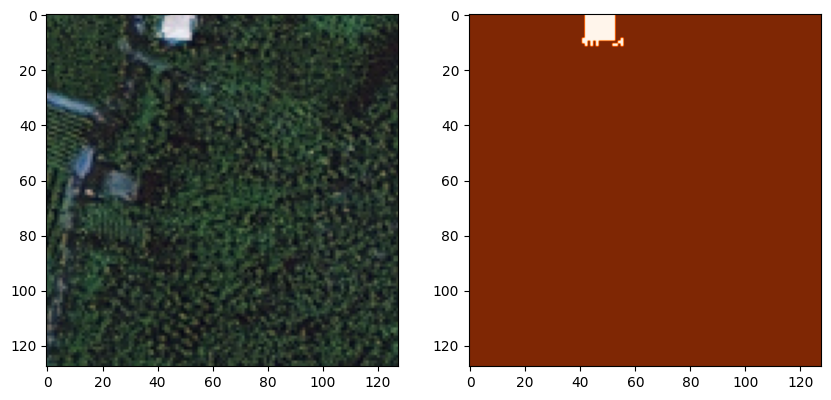

In [ ]:
"""
random_number = random.randint(0,500)

fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(X[random_number])
ax[1].imshow(y[random_number])
"""
random_number = random.randint(0,500)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X[random_number])


cmap = plt.get_cmap('Oranges_r')
masked_region = (y[random_number] != 1).astype(float)
ax[1].imshow(masked_region, cmap=cmap)

plt.show()

In [ ]:
## splitting the image into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=23)

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [ ]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
## creating and compiling a model

model = unet_model(n_filters=32,input_size=(128,128,3))

## let's use loss as binary_crossentropy since we have only two output fields: forest area and non-forest area
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/kaggle/working/forest_image_segmentor_model.h5",save_best_only=True)

In [ ]:
num_epochs = 5

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/5
144/144 [==============================] - 62s 255ms/step - loss: 0.5776 - accuracy: 0.7018 - val_loss: 0.5326 - val_accuracy: 0.7445
Epoch 2/5
144/144 [==============================] - 32s 220ms/step - loss: 0.5216 - accuracy: 0.7480 - val_loss: 0.4948 - val_accuracy: 0.7611
Epoch 3/5
144/144 [==============================] - 32s 225ms/step - loss: 0.4848 - accuracy: 0.7668 - val_loss: 0.5145 - val_accuracy: 0.7593
Epoch 4/5
144/144 [==============================] - 32s 221ms/step - loss: 0.6325 - accuracy: 0.7015 - val_loss: 0.5480 - val_accuracy: 0.7346
Epoch 5/5
144/144 [==============================] - 31s 215ms/step - loss: 0.5408 - accuracy: 0.7301 - val_loss: 0.5362 - val_accuracy: 0.7419


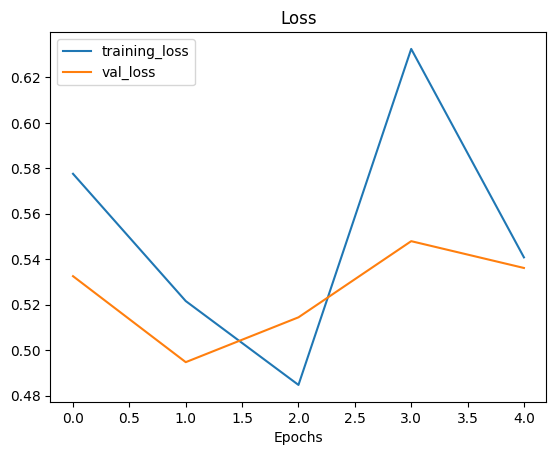

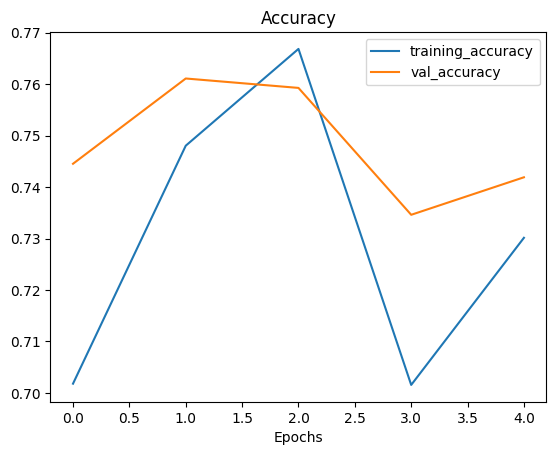

In [ ]:
plot_loss_curves(history)

1/1 [==============================] - 0s 18ms/step


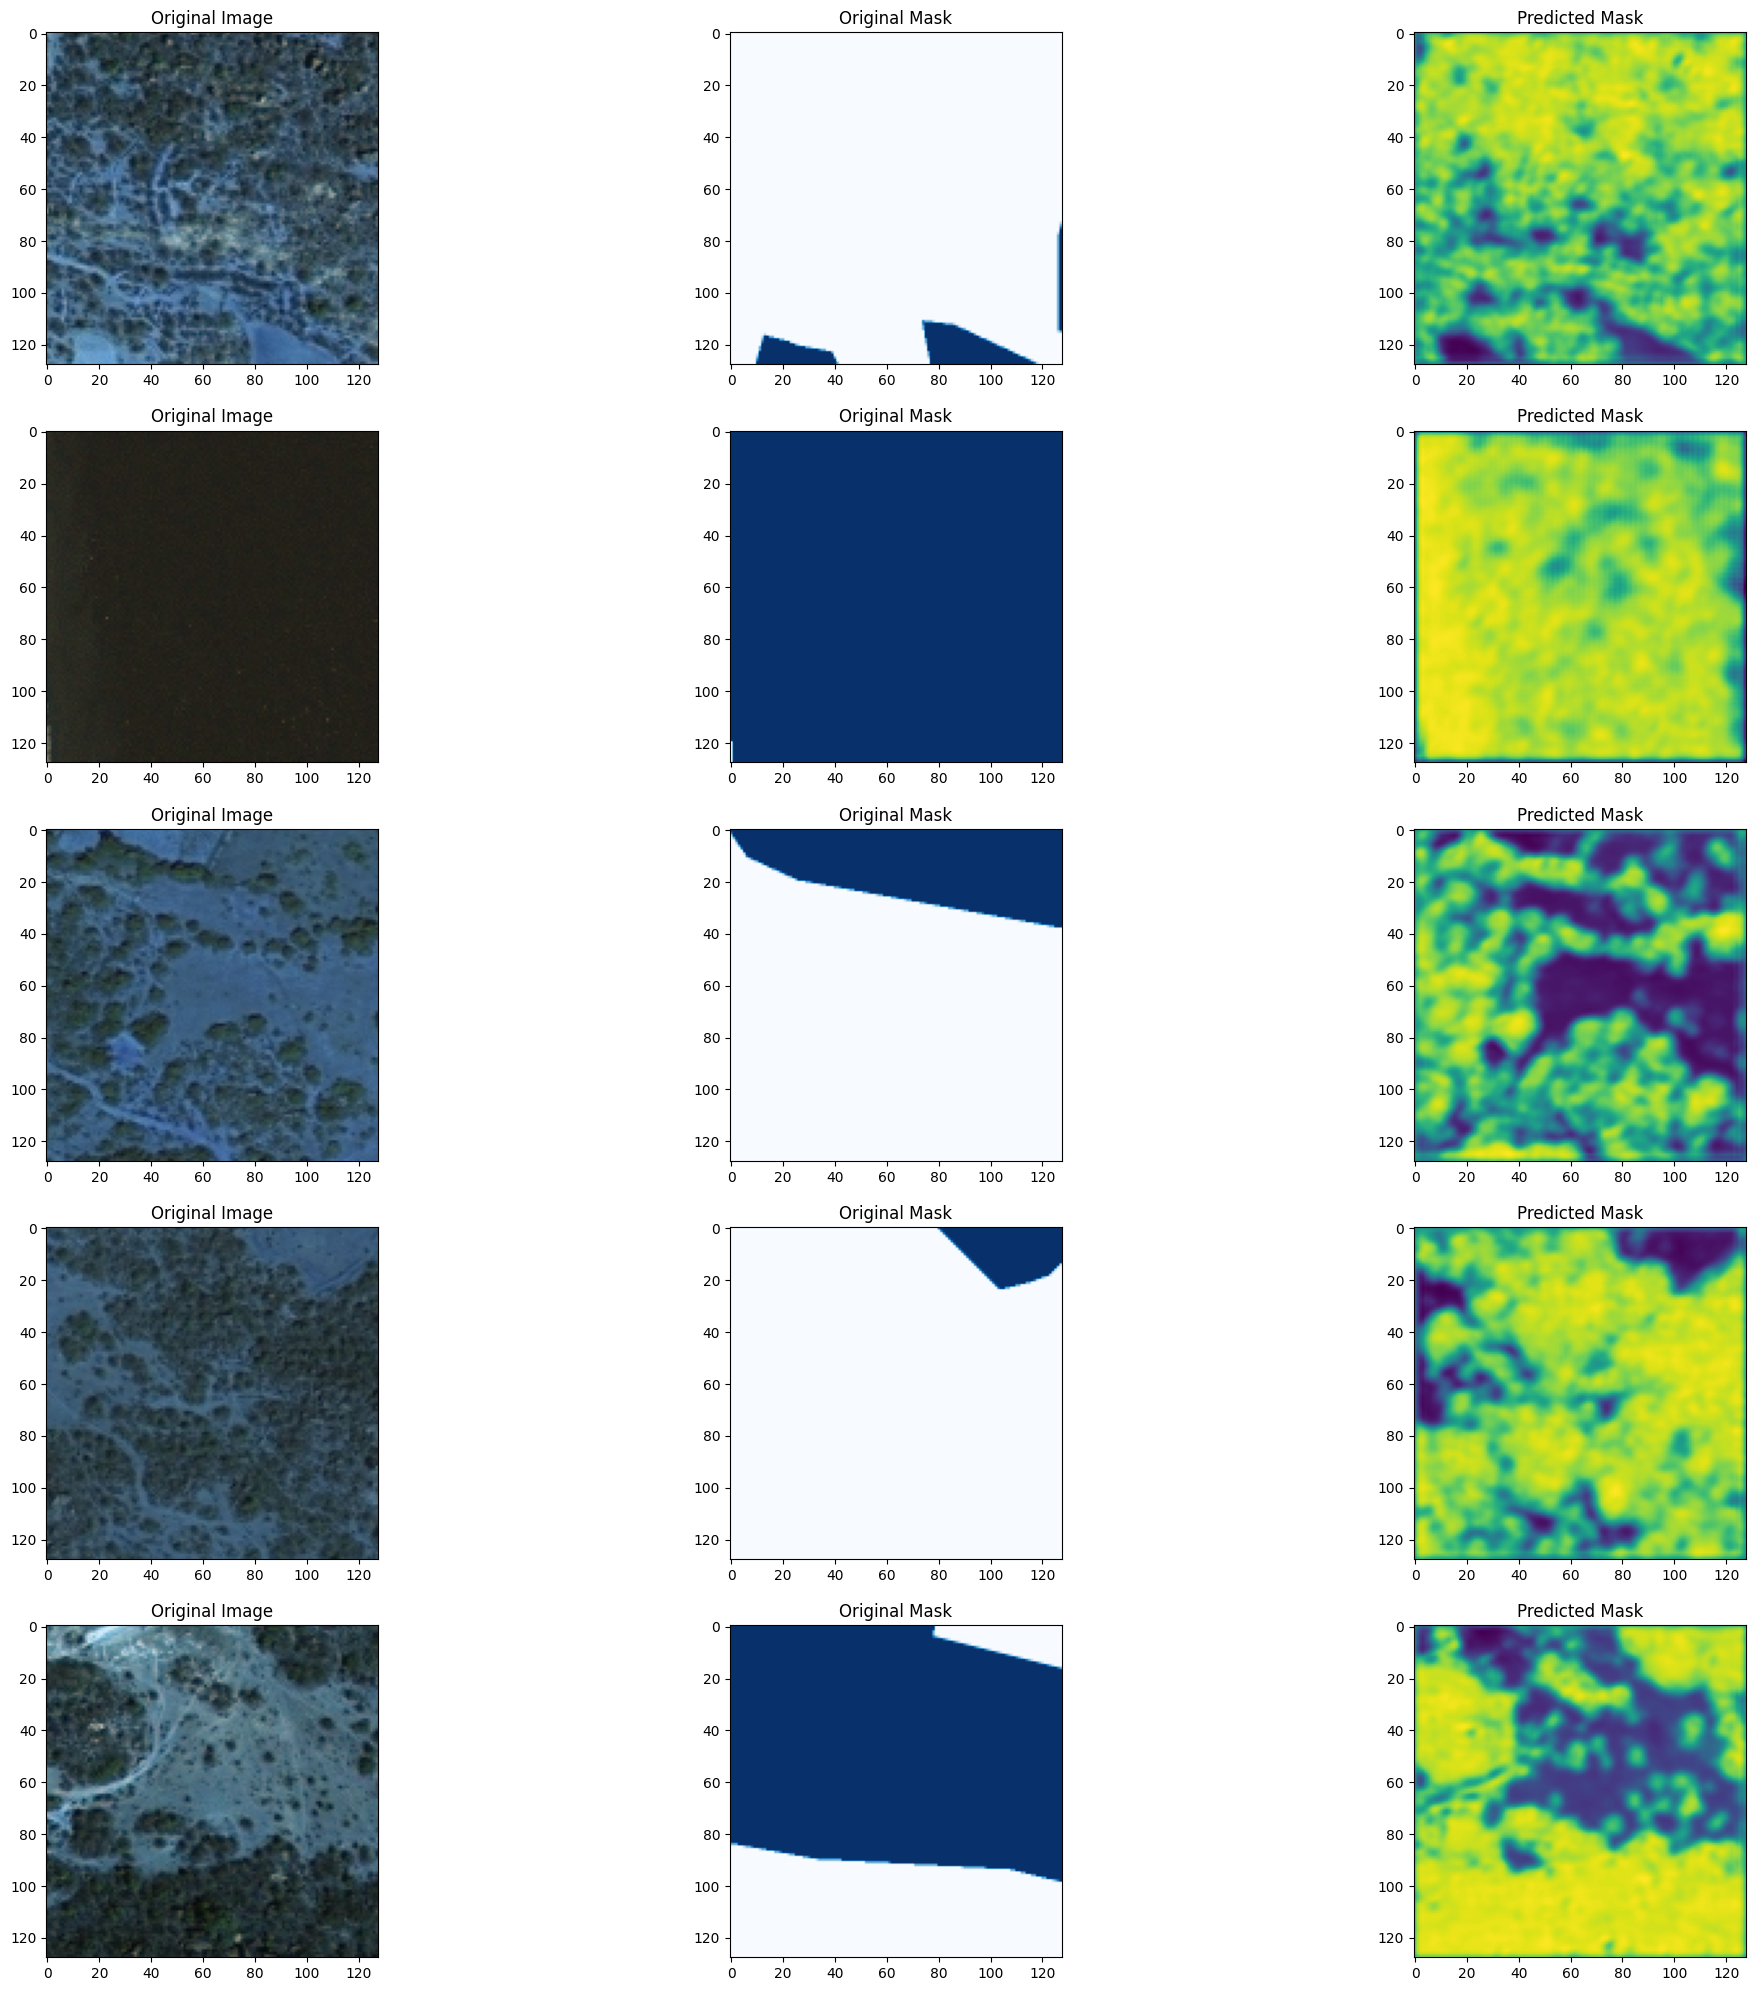

In [ ]:
figure, axes = plt.subplots(5,3, figsize=(25,25))

for i in range(0,5):
    rand_num = random.randint(0,400)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask,cmap='Blues_r')
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask)
    axes[i,2].title.set_text('Predicted Mask')